# Wildfire Data Analysis

Use the Table of Contents to navigate around.

**You don't have to run this code to view the result.**

But if you do, you will need a Google Earth Engine account.

# Gathering Data

Authentication and Initialization
---


In [4]:
import ee

ee.Authenticate()
ee.Initialize()

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)>

In [ ]:
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 40.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
import pandas as pd
from math import *

resolution_km = 1
requests = 1

km_lon_deg = 110.574  # Kilometers for 1 degree of longitude
km_lat_deg = 111.321  # Kilometers for 1 degree of latitude
dateRange = ["2021-08-05", "2021-08-06"]
fireName = "Dixie"

export_fire = False
export_wind = False

"""
Old Coordinates

"coordinates": [
    -121.5, 40.5,
    -118.5, 40.5,
    -118.5, 38.5,
    -121.5, 38.5,
]
"""

data = {
    "Dixie": {
        "coordinates": [
            -121.5, 40.5,
            -120.5, 40.5,
            -120.5, 39.5,
            -121.5, 39.5
        ]
    }
}


def getDataset():
    fire = data[fireName]

    # Get region from coordinates
    region = ee.Geometry.Polygon(fire["coordinates"])

    # Import dataset
    collection = ee.ImageCollection(dataset)

    # Selects the band (MaxFRP) and filters it by date
    collection = collection.select(band).filterDate(*dateRange[:2])

    if len(dateRange) > 2:
        collection = collection.filter(ee.Filter.calendarRange(dateRange[2], dateRange[3], "HOUR"))

    collection = collection.getRegion(region, resolution_km * 1000).getInfo()

    # Estimated area of the polygon
    lon = fire["coordinates"][::2]
    lat = fire["coordinates"][1::2]
    lon_km = abs(max(lon) - min(lon)) * km_lon_deg
    lat_km = abs(max(lat) - min(lat)) * km_lat_deg * (cos(lon[0] * (pi / 180)) * (180 / pi))
    print(lon_km * lat_km)

    return eeToDf(collection)


def eeToDf(arr):
    """Converts an ee.List to a Pandas.DataFrame."""

    print("Raw data")
    print(*arr[:5], sep="\n")
    df = pd.DataFrame(arr)

    if type(band) is str:
        bands = [band]
    else:
        bands = band

    headers = df.iloc[0]

    df = pd.DataFrame(df.values[1:], columns=headers)

    for b in bands:
        df[b] = pd.to_numeric(df[b])

    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    df = df[['datetime', *bands, 'longitude', 'latitude']]

    print(len(df))

    return df

Data Collection + Graphs
---

Fire data

In [3]:
dataset = "NOAA/GOES/17/FDCF"
band = "Power"
resolution_km = 2

fire_df = getDataset()
fire_df.dropna(inplace=True)
print("\nDataFrame preview", f"(size {len(fire_df)}):")
print(fire_df[:5])

export_fire = export_fire or True
if export_fire:
    # from google.colab import files

    fire_df.to_csv("fire_df.csv", index=False)

    # files.download("fire_df.csv")

EEException: Earth Engine client library not initialized. Run `ee.Initialize()`

In [ ]:
from collections import defaultdict

area = defaultdict(lambda: 0)
minimum = 9999
maximum = 0
maxTime = ""
threshold = 0
change = []
sum = 0
prev = None

for tup in fire_df.itertuples():
    power = tup[2]

    if pd.notna(power) and power >= threshold:
        if power < minimum:
            minimum = power
        elif power > maximum:
            maximum = power
            maxTime = tup[1].strftime("%-I:%M %P")

        if tup[0] % 10 == 0:
            change.append(power - prev)

        prev = power

        area[tup[1].strftime("%-I:%M %P")] += resolution_km * resolution_km

print(dict(area))
print(change)
print("Minimum fire radioactive power:", minimum / 10)
print("Maximum FRP:", maximum / 10)
print("Time of Maximum FRP:", maxTime)

{'8:00 pm': 431.25, '10:30 pm': 456.25, '10:40 pm': 481.25, '12:40 am': 431.25, '8:40 pm': 456.25, '8:30 pm': 443.75, '8:50 pm': 462.5, '9:00 pm': 425.0, '9:10 pm': 468.75, '9:20 pm': 450.0, '9:30 pm': 512.5, '9:40 pm': 475.0, '9:50 pm': 493.75, '11:10 pm': 468.75, '11:20 pm': 481.25, '11:30 pm': 437.5, '11:40 pm': 562.5, '11:50 pm': 568.75, '7:20 pm': 375.0, '7:30 pm': 368.75, '7:50 pm': 375.0, '8:10 pm': 506.25, '8:20 pm': 518.75, '10:00 pm': 512.5, '10:10 pm': 443.75, '10:20 pm': 400.0, '10:50 pm': 487.5, '11:00 pm': 412.5, '12:00 am': 387.5, '12:10 am': 337.5, '12:20 am': 306.25, '12:30 am': 375.0, '12:50 am': 331.25, '1:00 am': 312.5, '1:10 am': 281.25, '1:20 am': 325.0, '1:30 am': 243.75, '1:40 am': 237.5, '1:50 am': 281.25, '2:00 am': 268.75, '2:10 am': 325.0, '2:20 am': 287.5, '2:30 am': 218.75, '7:00 pm': 275.0, '7:10 pm': 343.75, '7:40 pm': 400.0, '2:40 am': 287.5, '2:50 am': 625.0, '3:00 am': 612.5, '3:10 am': 556.25, '3:20 am': 562.5, '3:30 am': 531.25, '3:40 am': 543.75, '

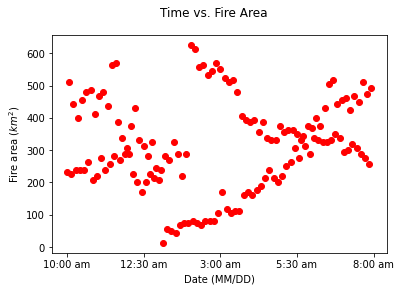

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

sortedArea = sorted(area.items())
keys = []
values = []

for date, value in sortedArea:
    keys.append(date)
    values.append(value)

xticks = sorted(list(keys)[::30])
plt.xticks(np.linspace(0, len(values), len(xticks)), xticks)
plt.plot(values, "ro")

plt.suptitle("Time vs. Fire Area")
plt.xlabel("Date (MM/DD)")
plt.ylabel("Fire area ($km^2$)")
plt.show()

Wind data

In [ ]:
dataset = "ECMWF/ERA5_LAND/HOURLY"
band = ["u_component_of_wind_10m", "v_component_of_wind_10m"]
resolution_km = 2
dateRange = ["2021-08-01", "2021-08-02"]

wind_df = getDataset()
# wind_df = wind_df[12::24]   # 2pm every day

speed = []
direction = []

for row in wind_df.itertuples(index=False):
    speed.append(abs(row[2]) + abs(row[1]))
    direction.append(atan(row[2] / row[1]) * (180 / pi))

wind_df["speed"] = speed
wind_df["direction"] = direction

wind_df.drop(columns=["u_component_of_wind_10m", "v_component_of_wind_10m"], inplace=True)

print("\nBand preview")
print(wind_df)

export_wind = export_wind or False
if export_wind:
    # from google.colab import files

    wind_df.to_csv("wind_df.csv", index=False)

    # files.download("wind_df.csv")

-368500.3066416035
Raw data
['id', 'longitude', 'latitude', 'time', 'u_component_of_wind_10m', 'v_component_of_wind_10m']
['20210801T00', -121.48591323611379, 39.51464356020745, 1627776000000, -0.4466552734375, 3.1544647216796875]
['20210801T01', -121.48591323611379, 39.51464356020745, 1627779600000, -0.6600799560546875, 3.215911865234375]
['20210801T02', -121.48591323611379, 39.51464356020745, 1627783200000, -1.0277862548828125, 2.641754150390625]
['20210801T03', -121.48591323611379, 39.51464356020745, 1627786800000, -1.4093475341796875, 2.307708740234375]
46464

Band preview
0                datetime   longitude   latitude     speed
0     2021-08-01 00:00:00 -121.485913  39.514644  3.601120
1     2021-08-01 01:00:00 -121.485913  39.514644  3.875992
2     2021-08-01 02:00:00 -121.485913  39.514644  3.669540
3     2021-08-01 03:00:00 -121.485913  39.514644  3.717056
4     2021-08-01 04:00:00 -121.485913  39.514644  3.942179
...                   ...         ...        ...       ...
464

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total vector count: 1936


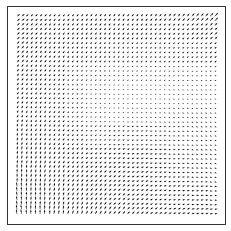

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cartopy.crs as ccrs

lat = np.array(wind_df["latitude"], dtype="float64")
lon = np.array(wind_df["longitude"], dtype="float64")
u = np.array(wind_df["u_component_of_wind_10m"], dtype="float64")
v = np.array(wind_df["v_component_of_wind_10m"], dtype="float64")

print("Total vector count:", len(lat))

fig = plt.figure()
coords = data[fireName]["coordinates"]
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.quiver(lon, lat, u, v)
plt.show()

# Data Analysis


Cross-Correlation
---

of the change in fire area vs. wind speed

$∑ v_{0(i+lag)} * v_{1(i+lag)}$

In [ ]:
lag = 0
correlation = 0

while correlation > 0:
    lag += 1

Creating a Grid
---

In [ ]:
uniqueCount = 0
prev = None

for tup in fire_df.itertuples(index=False):
    if prev is None:
        prev = tup[0]

    elif tup[0] == prev:
        break

    uniqueCount += 1

print(uniqueCount)

144


In [ ]:
def index(val, dir="lon"):
    if dir == "lon":
        return round((val - minLon) / increase)
    else:
        return round((val - minLat) / increase)


unique = np.unique(wind_df["longitude"])
increase = (unique[-1] - unique[0]) / (len(unique) - 1)
minLon = wind_df["longitude"].min()
minLat = wind_df["latitude"].min()
print("Increase:", increase)

length = index(wind_df["longitude"].max()) + 1
width = index(wind_df["latitude"].max(), "lat") + 1
grid = np.ndarray((length, width, 5))

print("Grid dimensions: ", length, "x", width, sep="")
print("Area:", length * width, "km^2")

Increase: 0.022457882102988012
Grid dimensions: 44x44
Area: 1936 km^2


In [ ]:
for tup in wind_df.itertuples(index=False):
    x = index(tup[4])
    y = index(tup[5], "lat")
    grid[x][y] = (tup[6], tup[7], 0, tup[3], False)

for tup in fire_df.itertuples(index=False):
    x = index(tup[2])
    y = index(tup[3], "lat")

    if tup[1]:
        grid[x][y][2] = tup[1]

print(grid[0][:10])

[[  3.87599182 -78.40088807          nan   2.51843262   0.        ]
 [  3.87599182 -78.40088807          nan   2.51843262   0.        ]
 [  3.34962463 -81.9517024           nan   2.78051758   0.        ]
 [  3.34962463 -81.9517024           nan   2.78051758   0.        ]
 [  3.34962463 -81.9517024           nan   2.78051758   0.        ]
 [  3.34962463 -81.9517024           nan   2.78051758   0.        ]
 [  3.34962463 -81.9517024           nan   2.78051758   0.        ]
 [  2.71012878  89.79117111          nan   3.57873535   0.        ]
 [  2.71012878  89.79117111          nan   3.57873535   0.        ]
 [  2.71012878  89.79117111          nan   3.57873535   0.        ]]


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

allColors = []
pos = []

for i in range(1):
    fire_no_nan = fire_df.iloc[i::uniqueCount]
    fire_no_nan = fire_no_nan[fire_no_nan.Power.notnull()]
    maximum = round(fire_no_nan["Power"].max())

    if i == 0:
        print(fire_no_nan[:3], "\nLength:", len(fire_no_nan))
        continue

    colors = [[1, 1, 1]]
    lon = [-118.5]
    lat = [40.6]
    for tup in fire_no_nan.itertuples(index=False):
        lon.append(tup[2])
        lat.append(tup[3])
        colors.append([tup[1] / maximum * 0.7 + 0.25, 0, 0])

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(lon, lat, c=colors, s=1)

plt.show()

0                     datetime       Power   longitude   latitude
161424 2021-08-05 00:00:31.900  119.615517 -121.014298  40.076091
166752 2021-08-05 00:00:31.900  189.555252 -121.171503  40.098548
166896 2021-08-05 00:00:31.900  259.639008 -121.149045  40.098548 
Length: 62


DFS Code
---

In [ ]:
MaxFRP = 2
isBoundary = 4

visited = np.full((length, width), False)

dx = [1, -1, 0, 0, 1, 1, 1, -1]
dy = [0, 0, 1, -1, 1, -1, 1, 1]
boundaryTileCount = 0


def dfs(x, y, start=True):
    global boundaryTileCount
    visited[x][y] = True
    tiles = []

    for i in range(4):
        newX = x + dx[i]
        newY = y + dy[i]

        if not 0 <= newX < length or not 0 <= newY < width:
            continue

        if np.isnan(grid[newX][newY][MaxFRP]):
            grid[x][y][isBoundary] = True
            continue

        if visited[newX][newY]:
            continue

        tiles.append((newX, newY))

    if grid[x][y][isBoundary]:
        for x, y in tiles:
            boundaryTileCount += 1
            dfs(x, y, False)


for tup in fire_no_nan.itertuples(index=False):
    startX = index(tup[2])
    startY = index(tup[3], "lat")

    if visited[startX][startY]:
        continue

    assert not np.isnan(grid[startX][startY][MaxFRP])

    dfs(startX, startY)

print("Boundary Tiles:", boundaryTileCount)

AssertionError: ignored